# Do some imports

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.utils.data
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset

#needed to create the Neural Network
import torch.nn as nn
import torch.nn.functional as F

#needed to preprocess the dataset
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

%matplotlib notebook
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dataloader import UNSW_NB15

#general
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


### Inspired by [this github file](https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20Torch%20MLP%20and%20autoEncoder.ipynb)

# Get UNSW_NB15 train and test set

In [2]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv

In [3]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv

# Define the Neural Network class

In [22]:
# define NN architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, num_classes):
        super(Net,self).__init__()
        self.input_size = input_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)     # linear layer (input_size -> hidden_size)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)  # linear layer (hidden_size -> hidden_2)
        
        self.fc3 = nn.Linear(hidden_size_2, num_classes)  # linear layer (hidden_size_2 -> num_classes)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
    def forward(self,x):        
        out = self.fc1(x)     #x is the input tensor
        
        out = self.relu1(out) #add hidden layer, with relu activation function
        out = self.fc2(out)
        
        out = self.relu2(out)   # add hidden layer, with relu activation function
        
        out = torch.sigmoid(self.fc3(out)) #sigmoid as we use BCELoss
        
        return out


In [23]:
def split_df_x_y(df1,df2) -> np.ndarray:
        """Splits dataframe into x and y numpy arrays. Y has the last column and the X has all the other"""
        x1 = df1.iloc[:, 0:-1].values
        y1 = df1.iloc[:, -1].values # Last column is the label
        x2 = df2.iloc[:, 0:-1].values
        y2 = df2.iloc[:, -1].values # Last column is the label
        return x1,y2,x2,y2

In [24]:
def train(model, device, train_loader, optimizer):
    model.train()
    losses = []
    y_true = []
    y_pred = []
    for i in train_loader:
        
        #LOADING THE DATA IN A BATCH
        data , target = i
        
        #MOVING THE TENSORS TO THE CONFIGURED DEVICE
        data, target = data.to(device), target.to(device)
        
        #FORWARD PASS
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))
        
        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # PREDICTIONS
        pred = np.round(output.detach())
        target = np.round(target.detach())
        y_pred.extend(pred.tolist())
        y_true.extend(target.tolist())
        
        losses.append(loss.item())
        
    print("Accuracy on training set is", accuracy_score(y_true,y_pred))
    return losses

In [25]:
#TESTING THE MODEL
def test(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in test_loader:
            
            #LOAD THE DATA IN A BATCH
            data,target = i
            
            # moving the tensors to the configured device
            data, target = data.to(device), target.to(device)
            
            # the model on the data
            output = model(data.float())
                       
            #PREDICTIONS
            pred = np.round(output)
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
    
            
    print("Accuracy on test set is" , accuracy_score(y_true,y_pred))
    print("***********************************************************")

## Define some parameters first

In [26]:
input_size = 196      # 42 for integer encoding
hidden_size = 64      # 1st layer number of neurons
hidden_size_2 = 64    # 2nd layer number of neurons
num_classes = 1    # There are  different classes

num_epochs = 2
learning_rate = 0.001
BATCH_SIZE_1 = 70 #train_loader as it has  175341  observations
BATCH_SIZE_2 = 51 #test_loader as it has  82332  observations

device = 'cpu'

## Initialize UNSW_NB15 class

In [27]:
#get the train dataframe
train_dataset = UNSW_NB15(file_path ='UNSW_NB15_training-set.csv')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_1, shuffle=True)

#get the test dataframe
test_dataset = UNSW_NB15(file_path ='UNSW_NB15_testing-set.csv')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_2, shuffle=True)


torch.Size([175341, 197])
torch.Size([82332, 197])


## Initialize Neural Network class

In [28]:
model = Net(input_size, hidden_size, hidden_size_2, num_classes).to(device)
print(model)

Net(
  (fc1): Linear(in_features=196, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
)


## Define loss and optimizer 

In [29]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train and Test the model

In [30]:
for epoch in tqdm(range(num_epochs)):
        losses = train(model,device,train_loader,optimizer)
        test(model,device,test_loader)

Accuracy on training set is 0.9995266366679784
Accuracy on test set is 0.9999878540543167
***********************************************************
Accuracy on training set is 1.0
Accuracy on test set is 0.9999878540543167
***********************************************************



## Check the loss

<IPython.core.display.Javascript object>


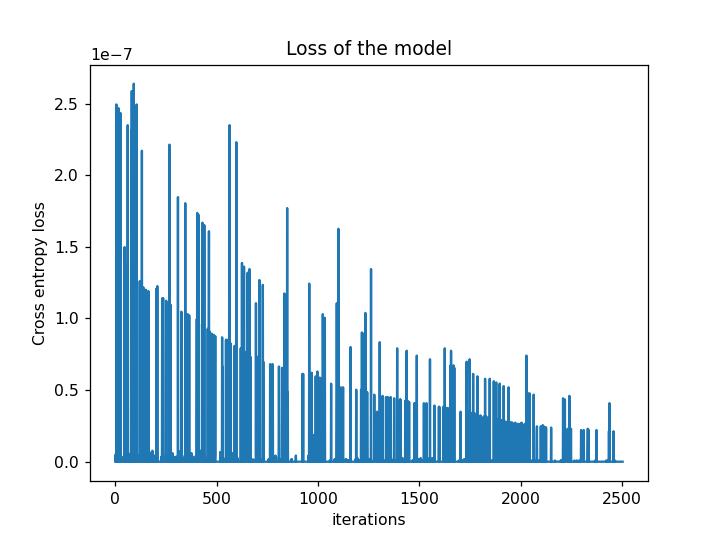

Text(0, 0.5, 'Cross entropy loss')

In [32]:
x_axis = [i for i in range(len(losses))]
plt.plot(x_axis,losses)
plt.title('Loss of the model')
plt.xlabel('iterations')
plt.ylabel('Cross entropy loss')

### Recreate this paper's results
    https://www.researchgate.net/publication/332100759_Intrusion_Detection_Using_Big_Data_and_Deep_Learning_Techniques

#### Just a simple example to try to understand this

In [ ]:
class LogisticModel(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LogisticModel, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    def forward(self, x):
        out = F.sigmoid(self.linear(x))
        return out

In [ ]:
model = LogisticModel(1,1)
model

In [ ]:
criterion = torch.nn.BCELoss(size_average = True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
epochs = 5
for epoch in range (epochs):
    epoch +=1
    x_train = torch.tensor([[1.6], [2.1], [1.3], [4.8], [3.5]], dtype=torch.float).reshape(-1,1)
    y_train = torch.tensor([[0], [0], [0], [1], [1]], dtype = torch.float).reshape(-1,1)
    
    inputs = x_train
    labels = y_train
    
    out = model(inputs)
    
    optimizer.zero_grad()
    loss = criterion(out,labels)
    
    loss.backward()
    optimizer.step()
    predicted = model.forward(x_train)
    print('Epoch {}, Loss {}'.format(epoch, loss.item()))
    print(model.state_dict())

In [ ]:
x_train.shape

In [ ]:
x = x_train.detach().numpy()
plt.plot(x, predicted.detach().numpy(), label ="predicted")
plt.plot(x, y_train.detach().numpy(),"go",label = "from data")
plt.legend()
plt.show()

#### Test the model

In [ ]:
test = torch.tensor([[0.1], [1.5], [2.3], [3.0], [6.4]])
results = model(test)
for result in results:
    if result < 0.5:
        print(result, "False")
    else:
        print(result, "True")